In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [74]:
car_path = os.path.abspath(os.path.join(os.path.dirname("__file__"),'..', 'users'))
file_path = os.path.join(car_path, 'registro_partidas.csv')
try:
    datos = pd.read_csv(file_path)
except FileNotFoundError:
    print("No se encontró el archivo")

In [75]:
def level_graphic():
    """ Porcentaje de partidas por nivel. """
    
    plt.clf()

    facil = datos[(datos['estado'] == 'finalizada') & (datos['nivel'] == 'Facil')]['nivel'].count()
    normal = datos[(datos['estado'] == 'finalizada') & (datos['nivel'] == 'Normal')]['nivel'].count()
    dificil = datos[(datos['estado'] == 'finalizada') & (datos['nivel'] == 'Dificil')]['nivel'].count()
    
    data_dibujo = [facil, normal, dificil]
    etiquetas = ['Facil', 'Normal', 'Dificil']
    plt.pie(data_dibujo, labels=etiquetas, autopct='%1.1f%%', shadow=True, startangle=90, labeldistance=1.1)
    plt.legend(etiquetas)
    plt.title('Porcentaje de partidas finalizadas por dificultad')
    plt.show()

In [76]:
def partidas_estado():
    """Gráfico que muestre el porcentaje de partidas por estado (fin, cancelada, error, timeout).
        También debe tener en cuenta las partidas que se terminaron inesperadamente o de forma repentina
        (partidas sin evento de fin)"""
    def partidas_con_error():
        """Partidas que no se terminaron debido a motivos externos a la app"""
        inicios_de_partida = datos[datos['evento'] == 'inicio_partida']['evento'].count()
        partidas_finalizadas = datos[datos['evento'] == 'fin']['evento'].count()
        canceladas = datos[datos['evento'] == 'cancelada']['evento'].count()

        return inicios_de_partida - (partidas_finalizadas + canceladas)


    fin = datos[(datos['estado']) == 'finalizada']['estado'].count()
    error = partidas_con_error()
    timeout = datos[(datos['estado']) == 'timeout']['estado'].count()
    cancelada = datos[(datos['estado']) == 'cancelada']['estado'].count()

    data_graf = [fin, error, timeout, cancelada]
    etiquetas = ['fin', 'error', 'timeout', 'cancelada']
    plt.pie(data_graf, labels=etiquetas, autopct='%1.1f%%', shadow=True, startangle=90, labeldistance=1.1)
    plt.legend(etiquetas)
    plt.title('Porcentaje de partidas por estado')
    plt.show()

In [77]:
def porcentaje_finalizado_genero():
    """Gráfico que muestre el porcentaje de partidas finalizadas por género"""
    

    plt.clf()


    masculino = datos[(datos['estado'] == 'finalizada') & (datos['genero'] == 'Masculino')]['genero'].count()
    femenino = datos[(datos['estado'] == 'finalizada') & (datos['genero'] == 'Femenino')]['genero'].count()
    otro = datos[(datos['estado'] == 'finalizada') & (datos['genero'] == 'Otro')]['genero'].count()


    data_dibujo = [masculino, femenino, otro]
    etiquetas = ['Masculino', 'Femenino', 'Otro']


    plt.pie(data_dibujo, labels=etiquetas, autopct='%1.1f%%', shadow=True, startangle=90, labeldistance=1.1)
    plt.legend(etiquetas)
    plt.title('Porcentaje de partidas finalizadas por género')
    plt.show()

In [78]:
def cant_errores():
    """Cantidadad de errores por usuarie"""
    usuarios = datos['usuarie'].unique()
    cant_errores = [datos[(datos['usuarie'] == usuario) & (datos['estado'] == 'error')]['usuarie'].count() for usuario in usuarios]
    plt.bar(usuarios, cant_errores)
    plt.title('Cantidad de errores por usuarie')
    plt.show()

In [79]:
def cant_timeout():
    """Cantidad de tarjetas para las que el usuarie no dio respuesta (timeout)"""
    usuarios = datos['usuarie'].unique()
    cant_timeout = [datos[(datos['usuarie'] == usuario) & (datos['estado'] == 'timeout')]['usuarie'].count() for usuario in usuarios]
    plt.bar(usuarios, cant_timeout)
    plt.title('Cantidad de timeout por usuarie')
    plt.show()

In [80]:
def porcentaje_por_usuario():
    """Porcentaje de aciertos por usuarie."""
    usuarios = datos['usuarie'].unique()
    #cantidad de intentos por usuario
    cant_intento = [datos[(datos['usuarie'] == usuario) & (datos['evento'] == 'intento')]['usuarie'].count() for usuario in usuarios]
    #cantidad de ok por usuario
    cant_ok = [datos[(datos['usuarie'] == usuario) & (datos['estado'] == 'ok')]['usuarie'].count() for usuario in usuarios]

    #porcentaje de ok por usuario
    porcentaje_ok = [cant_ok[i]*100/cant_intento[i] for i in range(len(cant_intento))]

    plt.bar(usuarios, porcentaje_ok)
    plt.title('Porcentaje de aciertos por usuarie.')
    plt.show()

In [81]:
def tiempo_partida():
    """Duración total de la partida (desde que el usuarie empieza a jugar hasta que presiona
        salir o pasan las N rondas definidas para el nivel de dificultad actual)."""

    df = datos[['timestamp', 'id', 'evento']]
    values = ['inicio_partida', 'fin']
    
    #arma un DF eliminando las filas que no son inicio_partida ni fin
    df = df[df['evento'].isin(values)]
    
    #elimina los inicio_partida repetidos, es decir, descartamos las partidas finalizadas por errores y nos quedamos sólo con
    #las finalizadas correctamente  y reseteo los indices
    df_ev = df['evento']
    indices_drop = df_ev[df_ev == df_ev.shift(-1)]
    
    df = df.drop(indices_drop.index).reset_index(drop=True)
    
    #hago la diferencia entre una fila y la anterior para obtener los tiempos
    df['timestamp'] = df['timestamp'].diff()
    
    #me quedo con las columnas que me interesan
    result = df[['id', 'timestamp']]
    
    #elimino las filas que muestran el tiempo entre el fin de una partida y el comienzo de otra
    result = result.drop(result.index[result.index % 2 == 0])
    
    #renombro las columnas para claridad
    result.rename(columns={'id': 'id_partida', 'timestamp': 'duracion_partida'}, inplace=True)
    result = result.set_index('id_partida')

    return result

In [82]:
def promedio_tiempo_partida():
    """Promedio de tiempo de partida general"""
    
    df = tiempo_partida()
    promedio = df.mean()
    print(f'El promedio general es de: {promedio["duracion_partida"]}')

In [83]:
def top_palabras():
    """Top 10 de palabras que se encuentran primero de todas las partidas."""

    top = datos['respuesta'].value_counts()
    del(top['-'])
    top_10 = top[:10]

    
    
    top_10.plot(kind='bar')
    plt.title ('top 10 palabras')
    plt.ylabel('cantidad de repaticiones')
    plt.xlabel('palabras')
    fig = plt.gcf()
    fig.set_size_inches(11, 4)
    
    plt.show()

In [84]:
def exitosa_mas_rapida():
    """ Tiempo de la respuesta exitosa más rápida."""
    
    df=datos[['timestamp', 'estado']]

    #agrego nueva columna para la resta de los tiempos
    df_2 = df.assign(tiempo_respuesta=0)


    #restar timestamp y guardar resultado en teimpo_respuesta
    df_2['tiempo_respuesta'] = df_2['timestamp'].diff()

    #busco los indices de las filas que no son una respuesta correcta
    indices=df_2[df_2['estado'] != 'ok'].index

    #elimino las filas de los indices encontrados
    df_ok=df_2.drop(indices)

    #busco el minimo en la columna tiempo_respuesta
    df_min=df_ok['tiempo_respuesta'].min()
    print(f'minimo:{df_min}')


In [85]:
def promedio_respuestas_exitosas():
    """Promedio de tiempo de respuesta para respuestas exitosas."""
    df=datos[['timestamp', 'estado']]

    #agrego nueva columna para la resta de los tiempos
    df_2 = df.assign(tiempo_respuesta=0)


    #restar timestamp y guardar resultado en teimpo_respuesta
    df_2['tiempo_respuesta'] = df_2['timestamp'].diff()

    #busco los indices de las filas que no son una respuesta correcta
    indices=df_2[df_2['estado'] != 'ok'].index

    #elimino las filas de los indices encontrados
    df_ok=df_2.drop(indices)

    #tamaño del frame que solo tiene las rtas correctas
    tam_df_ok=len(df_ok['tiempo_respuesta'])

    #sumar todos los elementos de la columna 'tiempo_respuesta'
    sum_tiempo_respuesta=df_ok['tiempo_respuesta'].sum()

    #dividir (suma total elementos)/(tamaño del frame)
    promedio=sum_tiempo_respuesta/tam_df_ok

    print(f'promedio: {promedio}')

# Graficos

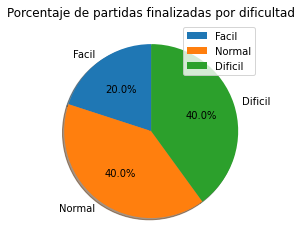

In [86]:
level_graphic()

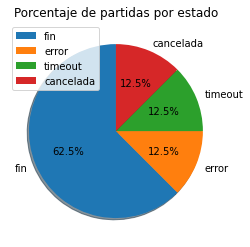

In [87]:
partidas_estado()

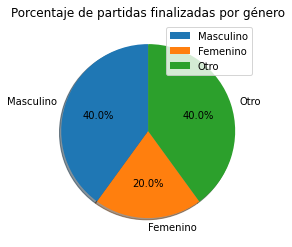

In [88]:
porcentaje_finalizado_genero()

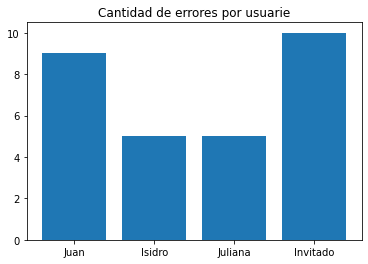

In [89]:
cant_errores()

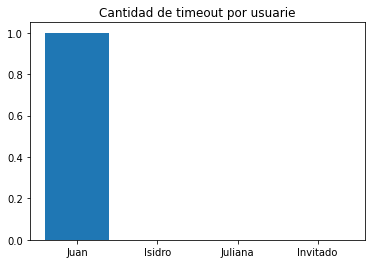

In [90]:
cant_timeout()

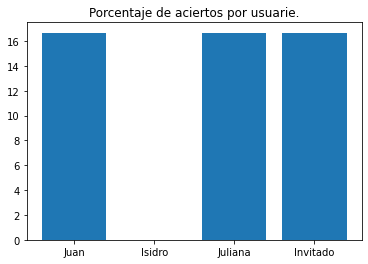

In [91]:
porcentaje_por_usuario()

In [92]:
tiempo_partida()

,duracion_partida
id_partida,
f6ac71ca-3314-42ea-a478-100bedd238de,7.0
fbfd10ee-413b-434c-bfac-ea0b94278a41,21.0
acc52a7e-1e84-46d6-bb03-3ba95b4b4297,4.0
29f91134-e64a-4395-b231-533ea2e2d7f4,4.0
2c0195ba-eb66-4009-8f93-3c8effbf89c1,5.0


In [93]:
promedio_tiempo_partida()

El promedio general es de: 8.2


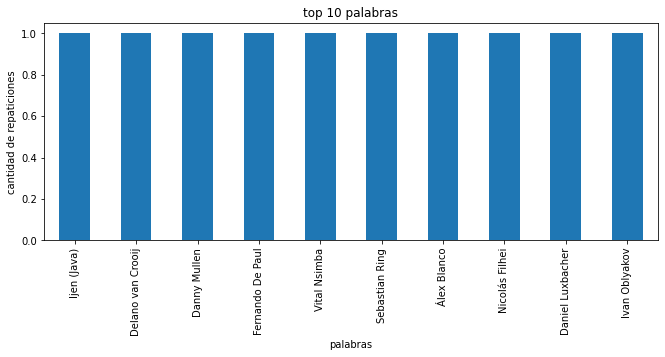

In [94]:
top_palabras()

In [95]:
exitosa_mas_rapida()

minimo:0.0


In [96]:
promedio_respuestas_exitosas()

promedio: 0.4
